In [0]:
import time
import argparse
import heapq
import random
import gym
import math
import numpy as np
from gym import wrappers, logger
from collections import deque
# from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Input
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import itertools

Using TensorFlow backend.


In [0]:
class PER_Memory():
    def __init__(self):
        self.memory = []
        self.tiebreak = itertools.count()

    def store_transition(self, transition, td_error):
        state, action, reward, next_state, done = transition
        event = (td_error, state, action, reward, next_state, done)
        heapq.heappush(self.memory, (next(self.tiebreak), event))

    def get_sample(self, sample_size):
        return [x[1] for x in heapq.nlargest(sample_size, self.memory)]

class DQNAgent_with_PER():
    def __init__(self, state_space, action_space, args, max_env_steps=None, gamma=0.95, batch_size=64, update_steps=10):


      self.epsilon = 1.0
      self.epsilon_min = 0.01
      self.epsilon_decay = 0.995
      self.alpha = 0.0005
      self.alpha_decay = 0.0
      self.n_episodes = 1000
      self.steps_target = 195
      self.gamma = gamma
      self.batch_size = batch_size
      self.update_steps = update_steps
      self.action_space = action_space
      self.replay_counter = 0
      env._max_episode_steps = max_env_steps
      self.epsilon_decay = 0.995
      
      n_inputs = state_space.shape[0]
      n_outputs = action_space.n
      
      self.q_model = self.build_model(n_inputs,n_outputs)
      self.target_q_model = self.build_model(n_inputs,n_outputs)
      
      # Q Network weights filename
      self.weights_file = 'ddqn_per_cartpole.h5'

      self.ddqn = True if args.ddqn else False
      if self.ddqn:
        print("----------Double DQN--------")
      else:
        print("-------------DQN------------")

      self.per =True if args.per else False

      if self.per:
        self.memory = PER_Memory()
        print("---------Use prioritized experience replay-------")

      else:
        self.memory = []
        print("-----------Use normal experience replay------------")

    
      
      
    # Q Network is 256-256-256 MLP
    def build_model(self, n_inputs, n_outputs):
        inputs = Input(shape=(n_inputs, ), name='state')
        x = Dense(256, activation='relu')(inputs)
        x = Dense(256, activation='relu')(x)
        x = Dense(256, activation='relu')(x)
        x = Dense(n_outputs, activation='linear', name='action')(x)
        q_model = Model(inputs, x)
        q_model.compile(loss='mse', optimizer=Adam())
        q_model.summary()
        return q_model

    

    # eps-greedy policy
    def act(self, state):
        if np.random.rand() < self.epsilon:
            # explore - do random action
            return self.action_space.sample()

        # exploit
        q_values = self.q_model.predict(state)
        # select the action with max Q-value
        return np.argmax(q_values[0])  
            

    def preprocess_state(self, state):
        return np.reshape(state, [1, 4])
    
    # save Q Network params to a file
    def save_weights(self):
        self.q_model.save_weights(self.weights_file)

    def get_target_q_value(self, next_state):
    # max Q value among next state's actions
        if self.ddqn:
            # DDQN
            # current Q Network selects the action
            # a'_max = argmax_a' Q(s', a')
            action = np.argmax(self.q_model.predict(next_state)[0])
            # target Q Network evaluates the action
            # Q_max = Q_target(s', a'_max)
            q_value = self.target_q_model.predict(next_state)[0][action]
        else:
            # DQN chooses the max Q value among next actions
            # selection and evaluation of action is on the target Q Network
            # Q_max = max_a' Q_target(s', a')
            q_value = np.amax(self.target_q_model.predict(next_state)[0])

        # Q_max = reward + gamma * Q_max
        q_value *= self.gamma
        q_value += reward
        return q_value

    # store experiences in the replay buffer
    def remember(self, state, action, reward, next_state, done):
        item = (state, action, reward, next_state, done)
        self.memory.append(item)
      
    # experience replay addresses the correlation issue between samples
    def replay(self, batch_size):
        # sars = state, action, reward, state' (next_state)
        sars_batch = random.sample(self.memory, batch_size)
        state_batch, q_values_batch = [], []

        # fixme: for speedup, this could be done on the tensor level
        # but easier to understand using a loop
        for state, action, reward, next_state, done in sars_batch:
            # policy prediction for a given state
            q_values = self.q_model.predict(state)

            # get Q_max
            q_value = self.get_target_q_value(next_state)

            # correction on the Q value for the action used
            q_values[0][action] = reward if done else q_value

            # collect batch state-q_value mapping
            state_batch.append(state[0])
            q_values_batch.append(q_values[0])

        # train the Q-network
        history = self.q_model.fit(np.array(state_batch),
                         np.array(q_values_batch),
                         batch_size=batch_size,
                         epochs=1,
                         verbose=0)

        loss = history.history['loss'][0]
        
        # update exploration-exploitation probability
        self.update_epsilon()

        # copy new params on old target after every 10 training updates
        if self.replay_counter % 10 == 0:
            self.update_weights()

        self.replay_counter += 1

        return loss  

    # experience replay addresses the correlation issue between samples
    def per_replay(self, batch_size):
        state_batch, q_values_batch = [], []
        minibatch = self.memory.get_sample(batch_size)
        for td_error, state, action, reward, next_state, done in minibatch:
            # policy prediction for a state
            q_values = self.q_model.predict(state)
            
            # get Q_max
            q_value = self.get_target_q_value(next_state)
            
            # correction on the Q value for the action used
            q_values[0][action] = reward if done else q_value
            
#             q_values[0][action] = reward
#             if not done:
#                 q_values[0][action] += self.gamma * np.max(self.target_q_model.predict(next_state)[0])

            # collect batch state q
            state_batch.append(state[0])
            q_values_batch.append(q_values[0])


        history = self.q_model.fit(np.array(state_batch), np.array(q_values_batch), batch_size=len(state_batch), epochs=1, verbose=0)
        
        
        loss = history.history['loss'][0]
        
        self.update_epsilon()

        # copy new params on old target after every 10 training updates
        if self.replay_counter % self.update_steps == 0:
            self.update_weights()
        
        self.replay_counter += 1
        
        return loss
      
    def update_weights(self):
        self.target_q_model.set_weights(self.q_model.get_weights())

        
    def compute_td_error(self, next_state, reward):
        Q_next = self.q_model.predict(next_state)[0]
        current = reward + self.gamma * np.max(self.target_q_model.predict(next_state)[0])
        td_error = abs(current - Q_next)
        return td_error

    
    # decrease the exploration, increase exploitation
    def update_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    def print_graphs(self,scores_log, loss_log):
        plt.rcParams['image.cmap'] = 'RdYlGn'
        plt.rcParams['figure.figsize'] = [15.0, 6.0]
        plt.rcParams['figure.dpi'] = 80
        plt.rcParams['savefig.dpi'] = 3
      
        plt.plot(range(len(score_log)), score_log[0:(len(score_log))], 'o')
        plt.title("Total reward per episode")
        plt.show()
		
        plt.plot(range(len(loss_log)), loss_log, 'o')
        plt.title("Total loss per episode")
        plt.show()

        avg_list = []
        for r in range(len(score_log) + 1):
            if r > 99:
                avg_list.append(np.mean(score_log[(r - 100): r]))
            else:
                avg_list.append(np.mean(score_log[(0): r]))

        plt.plot(range(len(avg_list)), avg_list, '-')
        plt.title("AVG reward per 100 episode")
        plt.show()

Namespace(ddqn=True, env_id='CartPole-v0', per=True)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
state (InputLayer)           (None, 4)                 0         
_________________________________________________________________
dense_37 (Dense)             (None, 256)               1280      
_________________________________________________________________
dense_38 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_39 (Dense)             (None, 256)               65792     
_________________________________________________________________
action (Dense)               (None, 2)                 514       
Total params: 133,378
Trainable params: 133,378
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)     

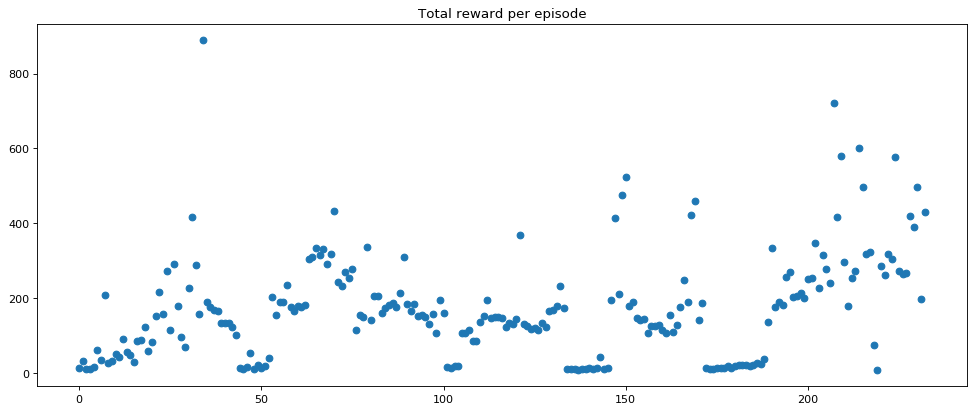

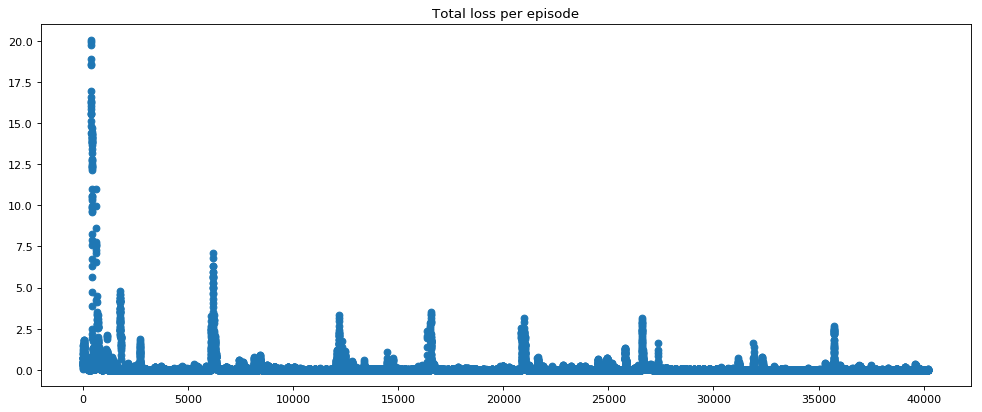

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


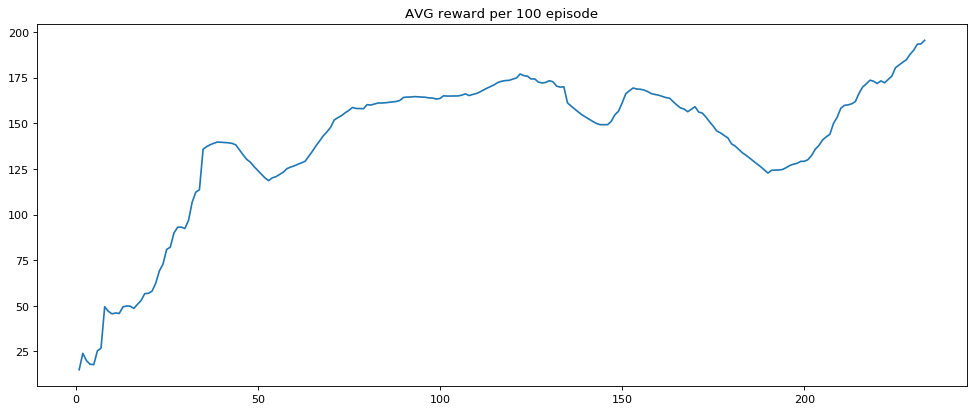

Runtime: 5264 seconds


In [0]:
if __name__ == '__main__':
        start = time.time()

        parser = argparse.ArgumentParser(description=None)
        parser.add_argument('env_id',
                            nargs='?',
                            default="CartPole-v0",
                            help='Select the environment to run')
        parser.add_argument("--ddqn",
                            action='store_true',
                            help="Use Double DQN ")
        parser.add_argument("--per",
                            action='store_true',
                            help="Use prioritized experience replay")
        # args = parser.parse_args()

        # For Jupyter Notebooks
        args = parser.parse_args(args=['--ddqn','--per'])
        print(args)
        # the number of trials without falling over
        win_trials = 100
#         win_trials = 10

    
        # the CartPole-v0 is considered solved if for 100 consecutive trials,
        # the cart pole has not fallen over and it has achieved an average 
        # reward of 195.0
        # a reward of +1 is provided for every timestep the pole remains upright
        win_reward = { 'CartPole-v0' : 195.0 }
#         win_reward = { 'CartPole-v0' : 10.0 } 

        # stores the reward per episode
        scores = deque(maxlen=win_trials)

        logger.setLevel(logger.ERROR)
        env = gym.make("CartPole-v0")
        env._max_episode_steps = 500

#         outdir = "/tmp/dqn-%s" % args.env_id
#         if args.ddqn:
#             outdir = "/tmp/ddqn-%s" % args.env_id
#         env = wrappers.Monitor(env, force=True)
#         env = wrappers.Monitor(env, directory=outdir, force=True)
        env.seed(0)

        score_log = []
        loss_log = []

        # instantiate the DDQN agentwith PER
        agent = DQNAgent_with_PER(env.observation_space, env.action_space, args)
        
        episode_count = 3000
        state_size = env.observation_space.shape[0]
        batch_size = 64


        if args.per:
            # steps = 0        
            for episode in range(episode_count):
                state = agent.preprocess_state(env.reset())
                done = False
                total_reward = 0.0


                while not done:
                    # in CartPole-v0, action=0 is left and action=1 is right
                    action = agent.act(state)                
                    next_state, reward, done, _ = env.step(action)

                    # in CartPole-v0:
                    # state = [pos, vel, theta, angular speed]
                    next_state = agent.preprocess_state(next_state)

                    # compute TD Error, amd store in prioritized exp. replay buffer
                    td_error = agent.compute_td_error(next_state, reward)
                    agent.memory.store_transition((state, action, reward, next_state, done), td_error)


                    loss = agent.per_replay(batch_size)
                    loss_log.append(loss)
                    state = next_state
                    total_reward += reward

                scores.append(total_reward)
                score_log.append(total_reward)
                mean_score = np.mean(scores)
                if mean_score >= win_reward['CartPole-v0'] and episode >= win_trials:
                    print('Done after {} episodes, with Average Reward {} over last {} episodes'.format(episode,mean_score,win_trials))
                    agent.print_graphs(score_log, loss_log)
                    agent.save_weights()
                    break

                if episode % 100 == 0:
                    print('[Episode {}] - Average reward over last 100 episodes was {}.'.format(episode, mean_score))

                if total_reward > 500:
                    print('Episode: {} got score of {} to the current avg of {}'.format(episode, total_reward, mean_score))

                if episode % 1000 == 0 and episode > 0:
                    agent.print_graphs()

            env.close()
            end = time.time()
            runtime = end - start
            print("Runtime: %d seconds" %(runtime))
            
        else:
            # Q-Learning sampling and fitting
            for episode in range(episode_count):
                state = env.reset()
                state = np.reshape(state, [1, state_size])
                done = False
                total_reward = 0
                while not done:
                    # in CartPole-v0, action=0 is left and action=1 is right
                    action = agent.act(state)
                    next_state, reward, done, _ = env.step(action)
                    # in CartPole-v0:
                    # state = [pos, vel, theta, angular speed]
                    next_state = np.reshape(next_state, [1, state_size])
                    # store every experience unit in replay buffer
                    agent.remember(state, action, reward, next_state, done)
                    state = next_state
                    total_reward += reward


                # call experience relay
                if len(agent.memory) >= batch_size:
                    loss = agent.replay(batch_size)
                    loss_log.append(loss)
            
                scores.append(total_reward)
                score_log.append(total_reward)
                mean_score = np.mean(scores)
                if mean_score >= win_reward[args.env_id] and episode >= win_trials:
                    print("Solved in episode %d: Mean survival = %0.2lf in %d episodes"
                          % (episode, mean_score, win_trials))
                    print("Epsilon: ", agent.epsilon)
                    agent.print_graphs(score_log, loss_log)
                    agent.save_weights()
                    break
                if episode % win_trials == 0:
                    print("Episode %d: Mean survival = %0.2lf in %d episodes" %
                          (episode, mean_score, win_trials))

            # close the env and write monitor result info to disk
            env.close()
            end = time.time()
            runtime = end - start
            print("Runtime: %d seconds" %(runtime))



### DDQN

Namespace(ddqn=True, env_id='CartPole-v0', per=False)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
state (InputLayer)           (None, 4)                 0         
_________________________________________________________________
dense_31 (Dense)             (None, 256)               1280      
_________________________________________________________________
dense_32 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_33 (Dense)             (None, 256)               65792     
_________________________________________________________________
action (Dense)               (None, 2)                 514       
Total params: 133,378
Trainable params: 133,378
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)    

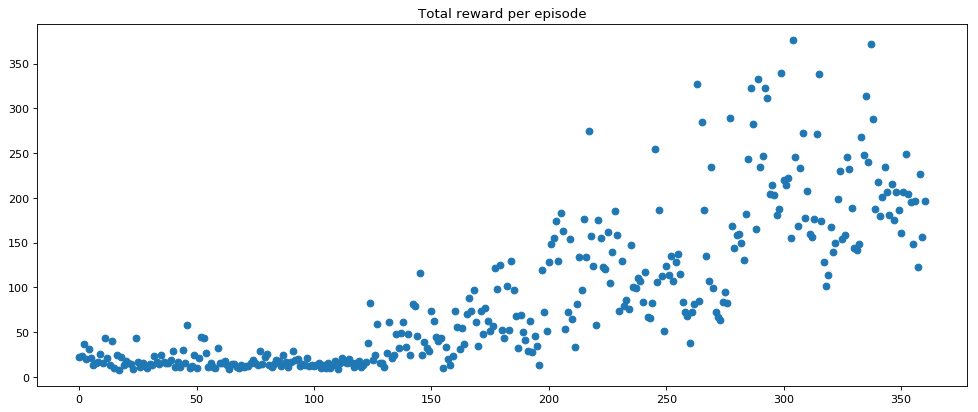

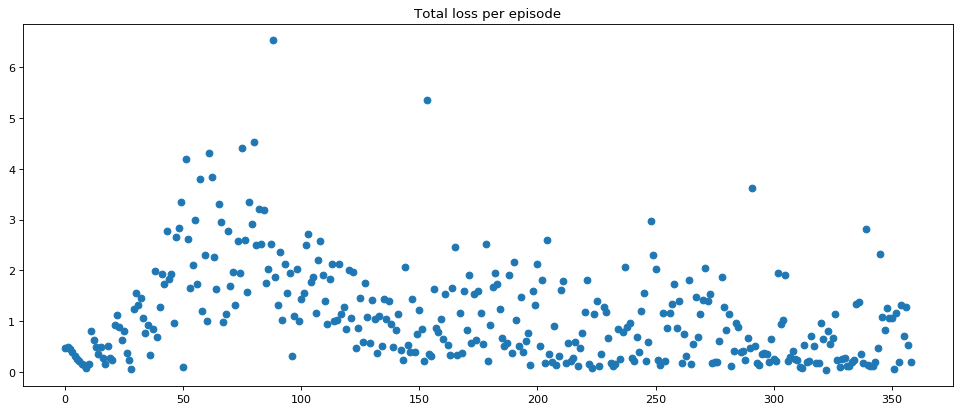

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


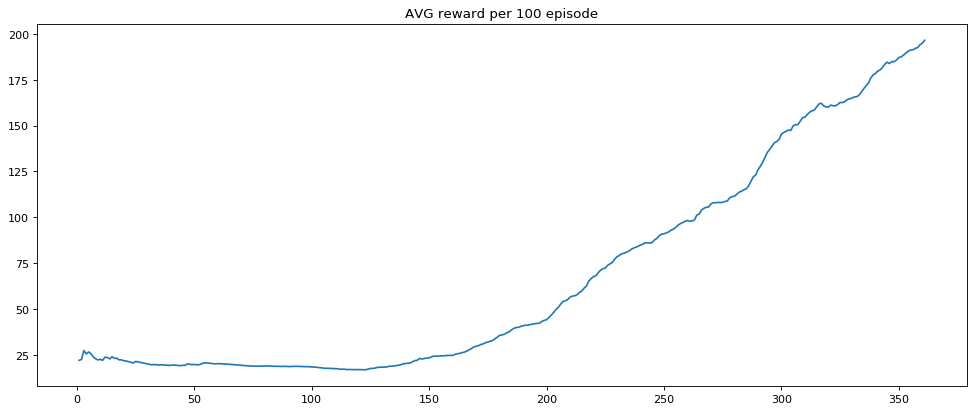

Runtime: 54 seconds


In [0]:

if __name__ == '__main__':
        start = time.time()

        parser = argparse.ArgumentParser(description=None)
        parser.add_argument('env_id',
                            nargs='?',
                            default="CartPole-v0",
                            help='Select the environment to run')
        parser.add_argument("--ddqn",
                            action='store_true',
                            help="Use Double DQN ")
        parser.add_argument("--per",
                            action='store_true',
                            help="Use prioritized experience replay")
        # args = parser.parse_args()

        # For Jupyter Notebooks
        args = parser.parse_args(args=['--ddqn'])
        print(args)
        # the number of trials without falling over
        win_trials = 100
#         win_trials = 10

    
        # the CartPole-v0 is considered solved if for 100 consecutive trials,
        # the cart pole has not fallen over and it has achieved an average 
        # reward of 195.0
        # a reward of +1 is provided for every timestep the pole remains upright
        win_reward = { 'CartPole-v0' : 195.0 }
#         win_reward = { 'CartPole-v0' : 10.0 } 

        # stores the reward per episode
        scores = deque(maxlen=win_trials)

        logger.setLevel(logger.ERROR)
        env = gym.make("CartPole-v0")
        env._max_episode_steps = 500

#         outdir = "/tmp/dqn-%s" % args.env_id
#         if args.ddqn:
#             outdir = "/tmp/ddqn-%s" % args.env_id
#         env = wrappers.Monitor(env, force=True)
#         env = wrappers.Monitor(env, directory=outdir, force=True)
        env.seed(0)

        score_log = []
        loss_log = []

        # instantiate the DDQN agentwith PER
        agent = DQNAgent_with_PER(env.observation_space, env.action_space, args)
        
        episode_count = 3000
        state_size = env.observation_space.shape[0]
        batch_size = 64


        if args.per:
            # steps = 0        
            for episode in range(episode_count):
                state = agent.preprocess_state(env.reset())
                done = False
                total_reward = 0.0


                while not done:
                    # in CartPole-v0, action=0 is left and action=1 is right
                    action = agent.act(state)                
                    next_state, reward, done, _ = env.step(action)

                    # in CartPole-v0:
                    # state = [pos, vel, theta, angular speed]
                    next_state = agent.preprocess_state(next_state)

                    # compute TD Error, amd store in prioritized exp. replay buffer
                    td_error = agent.compute_td_error(next_state, reward)
                    agent.memory.store_transition((state, action, reward, next_state, done), td_error)


                    loss = agent.per_replay(batch_size)
                    loss_log.append(loss)
                    state = next_state
                    total_reward += reward

                scores.append(total_reward)
                score_log.append(total_reward)
                mean_score = np.mean(scores)
                if mean_score >= win_reward['CartPole-v0'] and episode >= win_trials:
                    print('Done after {} episodes, with Average Reward {} over last {} episodes'.format(episode,mean_score,win_trials))
                    agent.print_graphs(score_log, loss_log)
                    agent.save_weights()
                    break

                if episode % 100 == 0:
                    print('[Episode {}] - Average reward over last 100 episodes was {}.'.format(episode, mean_score))

                if total_reward > 500:
                    print('Episode: {} got score of {} to the current avg of {}'.format(episode, total_reward, mean_score))

                if episode % 1000 == 0 and episode > 0:
                    agent.print_graphs()

            env.close()
            end = time.time()
            runtime = end - start
            print("Runtime: %d seconds" %(runtime))
            
        else:
            # Q-Learning sampling and fitting
            for episode in range(episode_count):
                state = env.reset()
                state = np.reshape(state, [1, state_size])
                done = False
                total_reward = 0
                while not done:
                    # in CartPole-v0, action=0 is left and action=1 is right
                    action = agent.act(state)
                    next_state, reward, done, _ = env.step(action)
                    # in CartPole-v0:
                    # state = [pos, vel, theta, angular speed]
                    next_state = np.reshape(next_state, [1, state_size])
                    # store every experience unit in replay buffer
                    agent.remember(state, action, reward, next_state, done)
                    state = next_state
                    total_reward += reward


                # call experience relay
                if len(agent.memory) >= batch_size:
                    loss = agent.replay(batch_size)
                    loss_log.append(loss)
            
                scores.append(total_reward)
                score_log.append(total_reward)
                mean_score = np.mean(scores)
                if mean_score >= win_reward[args.env_id] and episode >= win_trials:
                    print("Solved in episode %d: Mean survival = %0.2lf in %d episodes"
                          % (episode, mean_score, win_trials))
                    print("Epsilon: ", agent.epsilon)
                    agent.print_graphs(score_log, loss_log)
                    agent.save_weights()
                    break
                if episode % win_trials == 0:
                    print("Episode %d: Mean survival = %0.2lf in %d episodes" %
                          (episode, mean_score, win_trials))

            # close the env and write monitor result info to disk
            env.close()
            end = time.time()
            runtime = end - start
            print("Runtime: %d seconds" %(runtime))



### DQN + PER

Namespace(ddqn=False, env_id='CartPole-v0', per=True)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
state (InputLayer)           (None, 4)                 0         
_________________________________________________________________
dense_19 (Dense)             (None, 256)               1280      
_________________________________________________________________
dense_20 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_21 (Dense)             (None, 256)               65792     
_________________________________________________________________
action (Dense)               (None, 2)                 514       
Total params: 133,378
Trainable params: 133,378
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)    

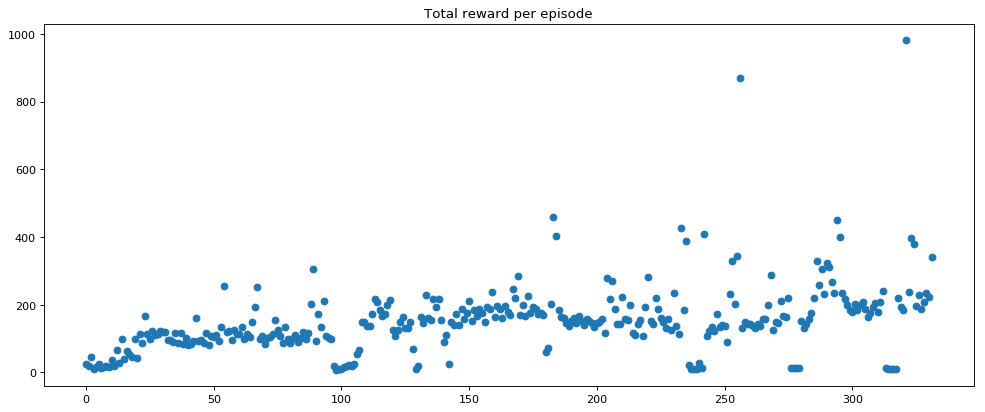

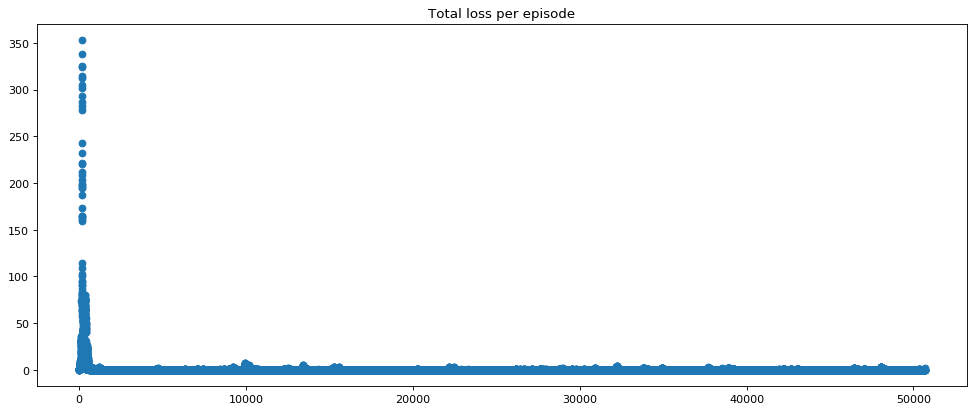

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


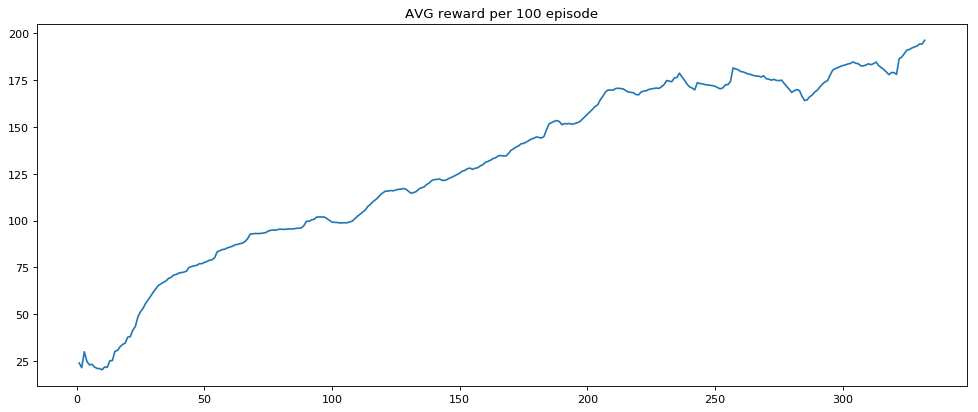

Runtime: 4778 seconds


In [0]:
if __name__ == '__main__':
        start = time.time()

        parser = argparse.ArgumentParser(description=None)
        parser.add_argument('env_id',
                            nargs='?',
                            default="CartPole-v0",
                            help='Select the environment to run')
        parser.add_argument("-dqn",
                            "--ddqn",
                            action='store_true',
                            help="Use Double DQN ")
        parser.add_argument("-er",
                            "--per",
                            action='store_true',
                            help="Use prioritized experience replay")
        # args = parser.parse_args()

        # For Jupyter Notebooks
        args = parser.parse_args(args=["--per"])
        print(args)
        # the number of trials without falling over
        win_trials = 100
#         win_trials = 10

    
        # the CartPole-v0 is considered solved if for 100 consecutive trials,
        # the cart pole has not fallen over and it has achieved an average 
        # reward of 195.0
        # a reward of +1 is provided for every timestep the pole remains upright
        win_reward = { 'CartPole-v0' : 195.0 }
#         win_reward = { 'CartPole-v0' : 10.0 } 

        # stores the reward per episode
        scores = deque(maxlen=win_trials)

        logger.setLevel(logger.ERROR)
        env = gym.make("CartPole-v0")
        env._max_episode_steps = 500

#         outdir = "/tmp/dqn-%s" % args.env_id
#         if args.ddqn:
#             outdir = "/tmp/ddqn-%s" % args.env_id
#         env = wrappers.Monitor(env, force=True)
#         env = wrappers.Monitor(env, directory=outdir, force=True)
        env.seed(0)

        score_log = []
        loss_log = []

        # instantiate the DDQN agentwith PER
        agent = DQNAgent_with_PER(env.observation_space, env.action_space, args)
        
        episode_count = 3000
        state_size = env.observation_space.shape[0]
        batch_size = 64


        if args.per:
            # steps = 0        
            for episode in range(episode_count):
                state = agent.preprocess_state(env.reset())
                done = False
                total_reward = 0.0


                while not done:
                    # in CartPole-v0, action=0 is left and action=1 is right
                    action = agent.act(state)                
                    next_state, reward, done, _ = env.step(action)

                    # in CartPole-v0:
                    # state = [pos, vel, theta, angular speed]
                    next_state = agent.preprocess_state(next_state)

                    # compute TD Error, amd store in prioritized exp. replay buffer
                    td_error = agent.compute_td_error(next_state, reward)
                    agent.memory.store_transition((state, action, reward, next_state, done), td_error)


                    loss = agent.per_replay(batch_size)
                    loss_log.append(loss)
                    state = next_state
                    total_reward += reward

                scores.append(total_reward)
                score_log.append(total_reward)
                mean_score = np.mean(scores)
                if mean_score >= win_reward['CartPole-v0'] and episode >= win_trials:
                    print('Done after {} episodes, with Average Reward {} over last {} episodes'.format(episode,mean_score,win_trials))
                    agent.print_graphs(score_log, loss_log)
                    agent.save_weights()
                    break

                if episode % 100 == 0:
                    print('[Episode {}] - Average reward over last 100 episodes was {}.'.format(episode, mean_score))

                if total_reward > 500:
                    print('Episode: {} got score of {} to the current avg of {}'.format(episode, total_reward, mean_score))

                if episode % 1000 == 0 and episode > 0:
                    agent.print_graphs()

            env.close()
            end = time.time()
            runtime = end - start
            print("Runtime: %d seconds" %(runtime))
            
        else:
            # Q-Learning sampling and fitting
            for episode in range(episode_count):
                state = env.reset()
                state = np.reshape(state, [1, state_size])
                done = False
                total_reward = 0
                while not done:
                    # in CartPole-v0, action=0 is left and action=1 is right
                    action = agent.act(state)
                    next_state, reward, done, _ = env.step(action)
                    # in CartPole-v0:
                    # state = [pos, vel, theta, angular speed]
                    next_state = np.reshape(next_state, [1, state_size])
                    # store every experience unit in replay buffer
                    agent.remember(state, action, reward, next_state, done)
                    state = next_state
                    total_reward += reward


                # call experience relay
                if len(agent.memory) >= batch_size:
                    loss = agent.replay(batch_size)
                    loss_log.append(loss)
            
                scores.append(total_reward)
                score_log.append(total_reward)
                mean_score = np.mean(scores)
                if mean_score >= win_reward[args.env_id] and episode >= win_trials:
                    print("Solved in episode %d: Mean survival = %0.2lf in %d episodes"
                          % (episode, mean_score, win_trials))
                    print("Epsilon: ", agent.epsilon)
                    agent.print_graphs(score_log, loss_log)
                    agent.save_weights()
                    break
                if episode % win_trials == 0:
                    print("Episode %d: Mean survival = %0.2lf in %d episodes" %
                          (episode, mean_score, win_trials))

            # close the env and write monitor result info to disk
            env.close()
            end = time.time()
            runtime = end - start
            print("Runtime: %d seconds" %(runtime))


### DQN

Namespace(ddqn=False, env_id='CartPole-v0', per=False)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
state (InputLayer)           (None, 4)                 0         
_________________________________________________________________
dense_61 (Dense)             (None, 256)               1280      
_________________________________________________________________
dense_62 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_63 (Dense)             (None, 256)               65792     
_________________________________________________________________
action (Dense)               (None, 2)                 514       
Total params: 133,378
Trainable params: 133,378
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)   

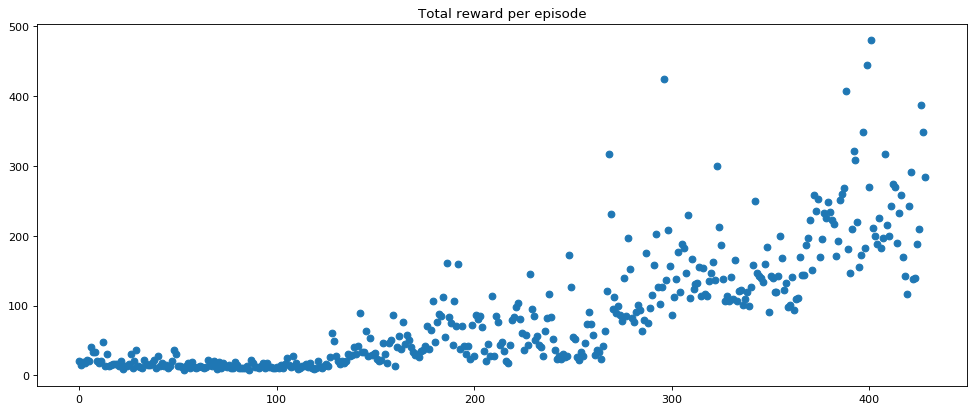

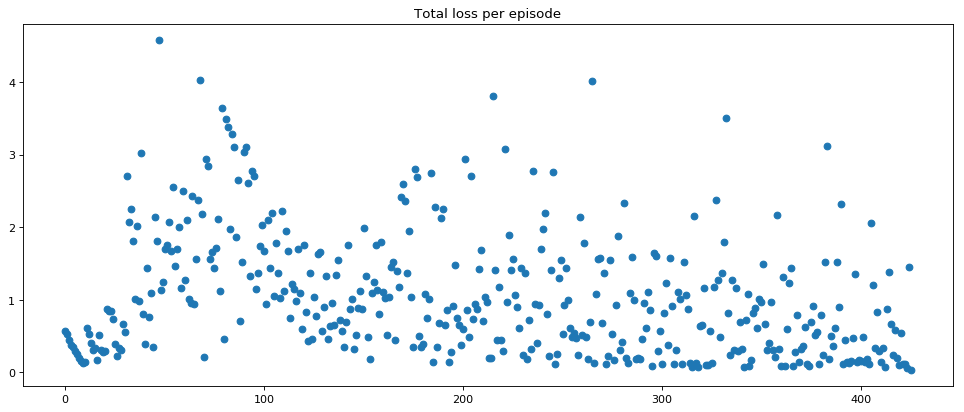

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


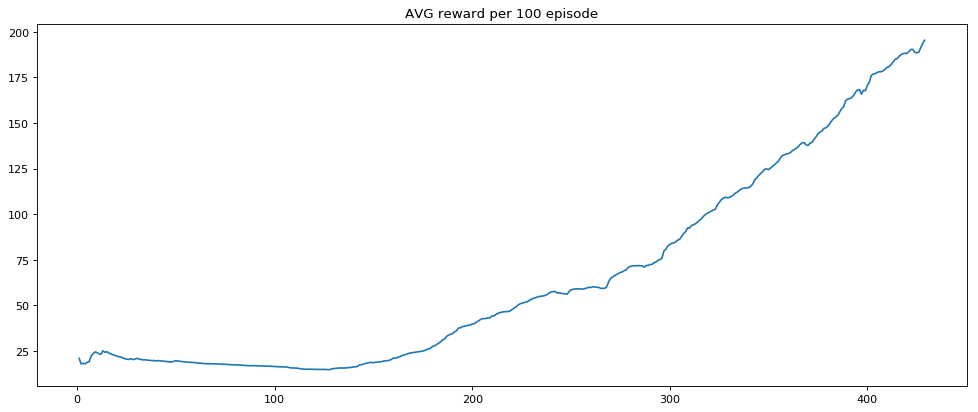

Runtime: 64 seconds


In [0]:

if __name__ == '__main__':
        start = time.time()

        parser = argparse.ArgumentParser(description=None)
        parser.add_argument('env_id',
                            nargs='?',
                            default="CartPole-v0",
                            help='Select the environment to run')
        parser.add_argument("-dqn",
                            "--ddqn",
                            action='store_true',
                            help="Use Double DQN ")
        parser.add_argument("-er",
                            "--per",
                            action='store_true',
                            help="Use prioritized experience replay")
        # args = parser.parse_args()

        # For Jupyter Notebooks
        args = parser.parse_args(args=[])
        print(args)
        # the number of trials without falling over
        win_trials = 100
#         win_trials = 10

    
        # the CartPole-v0 is considered solved if for 100 consecutive trials,
        # the cart pole has not fallen over and it has achieved an average 
        # reward of 195.0
        # a reward of +1 is provided for every timestep the pole remains upright
        win_reward = { 'CartPole-v0' : 195.0 }
#         win_reward = { 'CartPole-v0' : 10.0 } 

        # stores the reward per episode
        scores = deque(maxlen=win_trials)

        logger.setLevel(logger.ERROR)
        env = gym.make("CartPole-v0")
        env._max_episode_steps = 500

#         outdir = "/tmp/dqn-%s" % args.env_id
#         if args.ddqn:
#             outdir = "/tmp/ddqn-%s" % args.env_id
#         env = wrappers.Monitor(env, force=True)
#         env = wrappers.Monitor(env, directory=outdir, force=True)
        env.seed(0)

        score_log = []
        loss_log = []

        # instantiate the DDQN agentwith PER
        agent = DQNAgent_with_PER(env.observation_space, env.action_space, args)
        
        episode_count = 3000
        state_size = env.observation_space.shape[0]
        batch_size = 64


        if args.per:
            # steps = 0        
            for episode in range(episode_count):
                state = agent.preprocess_state(env.reset())
                done = False
                total_reward = 0.0


                while not done:
                    # in CartPole-v0, action=0 is left and action=1 is right
                    action = agent.act(state)                
                    next_state, reward, done, _ = env.step(action)

                    # in CartPole-v0:
                    # state = [pos, vel, theta, angular speed]
                    next_state = agent.preprocess_state(next_state)

                    # compute TD Error, amd store in prioritized exp. replay buffer
                    td_error = agent.compute_td_error(next_state, reward)
                    agent.memory.store_transition((state, action, reward, next_state, done), td_error)


                    loss = agent.per_replay(batch_size)
                    loss_log.append(loss)
                    state = next_state
                    total_reward += reward

                scores.append(total_reward)
                score_log.append(total_reward)
                mean_score = np.mean(scores)
                if mean_score >= win_reward['CartPole-v0'] and episode >= win_trials:
                    print('Done after {} episodes, with Average Reward {} over last {} episodes'.format(episode,mean_score,win_trials))
                    agent.print_graphs(score_log, loss_log)
                    agent.save_weights()
                    break

                if episode % 100 == 0:
                    print('[Episode {}] - Average reward over last 100 episodes was {}.'.format(episode, mean_score))

                if total_reward > 500:
                    print('Episode: {} got score of {} to the current avg of {}'.format(episode, total_reward, mean_score))

                if episode % 1000 == 0 and episode > 0:
                    agent.print_graphs()

            env.close()
            end = time.time()
            runtime = end - start
            print("Runtime: %d seconds" %(runtime))
            
        else:
            # Q-Learning sampling and fitting
            for episode in range(episode_count):
                state = env.reset()
                state = np.reshape(state, [1, state_size])
                done = False
                total_reward = 0
                while not done:
                    # in CartPole-v0, action=0 is left and action=1 is right
                    action = agent.act(state)
                    next_state, reward, done, _ = env.step(action)
                    # in CartPole-v0:
                    # state = [pos, vel, theta, angular speed]
                    next_state = np.reshape(next_state, [1, state_size])
                    # store every experience unit in replay buffer
                    agent.remember(state, action, reward, next_state, done)
                    state = next_state
                    total_reward += reward


                # call experience relay
                if len(agent.memory) >= batch_size:
                    loss = agent.replay(batch_size)
                    loss_log.append(loss)
            
                scores.append(total_reward)
                score_log.append(total_reward)
                mean_score = np.mean(scores)
                if mean_score >= win_reward[args.env_id] and episode >= win_trials:
                    print("Solved in episode %d: Mean survival = %0.2lf in %d episodes"
                          % (episode, mean_score, win_trials))
                    print("Epsilon: ", agent.epsilon)
                    agent.print_graphs(score_log, loss_log)
                    agent.save_weights()
                    break
                if episode % win_trials == 0:
                    print("Episode %d: Mean survival = %0.2lf in %d episodes" %
                          (episode, mean_score, win_trials))

            # close the env and write monitor result info to disk
            env.close()
            end = time.time()
            runtime = end - start
            print("Runtime: %d seconds" %(runtime))
